# Projet 2

## Sommaire

► consigne </br>
► setup </br>
► analyse qualitative </br>
► analyse quantative </br>
► évaluation

***
# consigne

Mark, votre manager, vous a convié à une réunion pour vous présenter le projet d’expansion à l’international de l’entreprise. Il vous confie une première mission d’analyse exploratoire, pour déterminer si les données sur l’éducation de la banque mondiale permettent d’informer le projet d’expansion.

Voici les différentes questions que Mark aimerait explorer, que vous avez notées durant la réunion :

 - Quels sont les pays avec un fort potentiel de clients pour nos services ?
 - Pour chacun de ces pays, quelle sera l’évolution de ce potentiel de clients ?
 - Dans quels pays l'entreprise doit-elle opérer en priorité ?
Votre mission
Mark vous a donc demandé de réaliser une analyse pré-exploratoire de ce jeu de données. Il vous a transmis cet email à la suite de la réunion :

*Hello,*

*Les données de la Banque mondiale sont disponibles à l’adresse suivante :*

*https://datacatalog.worldbank.org/dataset/education-statistics*

*Ou en téléchargement direct à ce lien.*

*Je te laisse regarder la page d'accueil qui décrit le jeu de données. En résumé, l’organisme “EdStats All Indicator Query” de la Banque mondiale répertorie 4000 indicateurs internationaux décrivant l’accès à l’éducation, l’obtention de diplômes et des informations relatives aux professeurs, aux dépenses liées à l’éducation... Tu trouveras plus d'info sur ce site :*

*http://datatopics.worldbank.org/education/*

*Pour la pré-analyse, pourrais-tu :*

 - *Valider la qualité de ce jeu de données (comporte-t-il beaucoup de données manquantes, dupliquées ?)*
 - *Décrire les informations contenues dans le jeu de données (nombre de colonnes ? nombre de lignes ?)*
 - *Sélectionner les informations qui semblent pertinentes pour répondre à la problématique (quelles sont les colonnes contenant des informations qui peuvent être utiles pour répondre à la problématique de l’entreprise ?)*
 - *Déterminer des ordres de grandeurs des indicateurs statistiques classiques pour les différentes zones géographiques et pays du monde (moyenne/médiane/écart-type par pays et par continent ou bloc géographique)*
 
*Ton travail va nous permettre de déterminer si ce jeu de données peut informer les décisions d'ouverture vers de nouveaux pays. On va partager ton analyse avec le board, alors merci de soigner la présentation et de l'illustrer avec des graphiques pertinents et lisibles !*

Livrables attendus
 - Un notebook comportant les analyses pré-exploratoires réalisées (non cleané, pour comprendre votre démarche).
 - Un support de présentation pour la soutenance.

***
# Setup

### import des bibliothèques

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import ipywidgets as widgets
import markdown

%matplotlib

from datetime import datetime, timezone, timedelta, date
from IPython.display import display as Idisplay
from IPython.display import clear_output, HTML
from matplotlib import pylab

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.ioff()

Using matplotlib backend: <object object at 0x000001A9012A9620>


### import des données

In [2]:
EdStatsCountry = pd.read_csv("csv_data/EdStatsCountry.csv")
EdStatsCountry_Series = pd.read_csv("csv_data/EdStatsCountry-Series.csv")
EdStatsData = pd.read_csv("csv_data/EdStatsData.csv")
EdStatsFootNote = pd.read_csv("csv_data/EdStatsFootNote.csv")
EdStatsSeries = pd.read_csv("csv_data/EdStatsSeries.csv")

***
# Analyse Qualitative

premier coup d'oeuil avec une carte des liens entre les tables

![title](img\table_chart.png)

### affichage des données manquantes sous forme de matrice binaire (Noir = présent, Blanc = manquant)

In [3]:
Tables = [EdStatsCountry, EdStatsCountry_Series, EdStatsData, EdStatsFootNote, EdStatsSeries]
T_Names = ["EdStatsCountry", "EdStatsCountry-Series", "EdStatsData", "EdStatsFootNote", "EdStatsSeries"]

for t,n in zip(Tables, T_Names):
    t.name = n
    print(f"{n} est de taille {t.shape}")

def draw_missing_values(ds_str, fig, ax):
    t = Tables[T_Names.index(ds_str)]
    msno.matrix(t, ax=ax, sparkline=False)
    ax.set_title(t.name)
    fig.tight_layout(pad=2)

EdStatsCountry est de taille (241, 32)
EdStatsCountry-Series est de taille (613, 4)
EdStatsData est de taille (886930, 70)
EdStatsFootNote est de taille (643638, 5)
EdStatsSeries est de taille (3665, 21)


In [4]:
msnowidget = widgets.Dropdown(options=T_Names)
output_miss = widgets.Output()

with output_miss :
    fig, ax = plt.subplots(figsize=(9,10))
    draw_missing_values("EdStatsCountry", fig, ax)
    Idisplay(fig)

def msnowidget_eventhandler(change):
    with output_miss :
        clear_output()
        draw_missing_values(change.new, fig, ax)
        Idisplay(fig)

msnowidget.observe(msnowidget_eventhandler, names='value')

Idisplay(msnowidget, output_miss)

Dropdown(options=('EdStatsCountry', 'EdStatsCountry-Series', 'EdStatsData', 'EdStatsFootNote', 'EdStatsSeries'…

Output()

***
# Analyse Quantitative

préparation de tableaux utiles pour l'affichage

In [5]:
indicators = EdStatsSeries["Indicator Name"].to_numpy()
#liste des éléments de "Country Name" qui ne sont pas des états mais des aggrégats d'états
regions =  ['Arab World',
            'East Asia & Pacific',
            'East Asia & Pacific (all income levels)',
            'East Asia & Pacific (excluding high income)',
            'Europe & Central Asia',
            'Europe & Central Asia (all income levels)',
            'Europe & Central Asia (excluding high income)',
            'Euro area',
            'European Union',
            'Heavily indebted poor countries (HIPC)',
            'High income',
            'Latin America & Caribbean',
            'Latin America & Caribbean (all income levels)',
            'Latin America & Caribbean (excluding high income)',
            'Least developed countries: UN classification',
            'Low income',
            'Lower middle income',
            'Low & middle income',
            'Middle East & North Africa',
            'Middle East & North Africa (all income levels)',
            'Middle East & North Africa (excluding high income)',
            'Middle income',
            'North America',
            'OECD members',
            'South Asia',
            'Sub-Saharan Africa',
            'Sub-Saharan Africa (all income levels)',
            'Sub-Saharan Africa (excluding high income)',
            'Upper middle income',
            'World']
countries = EdStatsCountry["Table Name"].to_numpy()

Dates = [date(year, 1, 1) for year in list(range(1970,2018,1))+list(range(2020,2101,5))]
Dates_string = [str(d.year) for d in Dates]

préparation de fonctions pour l'extraction des données depuis les datasets

In [6]:
def get_Y_values(dataframe, indicator:str, country:str):
    Q = EdStatsData.query("`Indicator Name` == @indicator & `Country Name` == @country")
    return Q[Dates_string].to_numpy().ravel()
    
def get_indi_missing(dataframe, indicator:str, country:str):
    Q = EdStatsData.query("`Indicator Name` == @indicator")
    return Q[Dates_string].isna().mean(axis=1).to_numpy(), Q.isna().mean(axis=0)[Dates_string].to_numpy(), Q.reset_index().query("`Country Name`== @country").index[0]

def get_cty_missing(dataframe, indicator:str, country:str):
    Q = EdStatsData.query("`Country Name` == @country")
    return Q[Dates_string].isna().mean(axis=1).to_numpy(), Q.isna().mean(axis=0)[Dates_string].to_numpy(), Q.reset_index().query("`Indicator Name` == @indicator").index[0]

création de widgets pour l'affichage dynamique

In [7]:
options = [(d.strftime('%Y'), d) for d in Dates]
date_slider = widgets.SelectionRangeSlider(options=options,
                                           index=(0,55),
                                           description='Période',
                                           disabled=False)

indicators_combobox = widgets.Combobox(
    value='Population, total',
    placeholder='',
    options=list(indicators),
    description='Indicator',
    ensure_option=True,
    disabled=False
)

countries_combobox = widgets.Combobox(
    value='France',
    placeholder='',
    options=list(countries),
    description='Country',
    ensure_option=True,
    disabled=False
)

creation de l'objet qui gère l'affichage dynamique

In [8]:
# Cette classe encapsule la gestion de l'affichage dynamique des indicateurs et de leurs données manquantes
class Displayer :
    
    def __init__(self, DS, indi, country):
        self.dataset = DS
        self.indi = indi
        self.country = country
        self.X = np.array(Dates)
        self.d_start = min(self.X)
        self.d_end = max(self.X)
        self.mask = np.full(len(self.X), True)
        self.fig, self.ax = None, None
        self.fig1, self.ax1 = None, None
        self.fig2, self.ax2 = None, None
        self.out = widgets.Output()
        self.indi_miss = widgets.Output()
        self.cty_miss = widgets.Output()
    
    def change_dates(self, new_date_start, new_date_end):
        self.d_start = new_date_start
        self.d_end = new_date_end
        self._UPDATE_MASK()
    
    def change_country(self, new_country):
        self.country = new_country
        self._country_missing()
    
    def change_indi(self, new_indi):
        self.indi = new_indi
    
    def _UPDATE_MASK(self):
        self.mask = np.array([self.d_start <= date <= self.d_end for date in self.X])
    
    def _plot(self):
        with self.out :
            clear_output()
            if self.fig==None :
                self.fig, self.ax = plt.subplots(figsize=(9,6), 
                                                 num=f"{self.country}-{self.indi}")
            else :
                self.fig.set(label = f"{self.country}-{self.indi}")
            
            try :
                YY = get_Y_values(self.dataset, self.indi, self.country)
            except Exception as e :
                YY = np.full(len(self.mask), np.nan)
            
            fig, ax = self.fig, self.ax
            ax.clear()
            ax.plot(self.X[self.mask], 
                    YY[self.mask],
                    zorder=1)

            ax.grid(zorder=0)
            fig.tight_layout()
            Idisplay(fig)
            Idisplay(pd.DataFrame(YY[self.mask]).apply(pd.Series.describe, axis=0).transpose())
    
    def _indicator_missing(self):
        with self.indi_miss :
            clear_output()
            if self.fig1==None :
                self.fig1, self.ax1 = plt.subplots(3, 1, 
                                                   figsize=(9,35), 
                                                   height_ratios = [15,10,5], 
                                                   num=f"{self.indi[:50]}")
            else :
                self.fig1.set(label = f"{self.indi[:50]}")
            fig1, ax1 = self.fig1, self.ax1
            miss_tab, miss_date, cty_index = get_indi_missing(self.dataset, self.indi, self.country)
            N = len(miss_tab)
            
            ax1[0].clear()
            bars = ax1[0].barh(range(N), miss_tab/max(miss_tab))
            bars[cty_index].set_color('r')
            ax1[0].set_title(f'valeurs manquantes par pays')
            ax1[0].set_yticks([])
            ax1[0].set_ylim(-1, N+1)
            
            ax1[1].clear()
            bars = ax1[1].barh(range(len(miss_date)), miss_date/max(miss_date))
            ax1[1].set_title(f'valeurs manquantes par année')
            ax1[1].set_ylim(-1, len(miss_date)+1)
            ax1[1].set_yticks(np.arange(len(Dates_string)), Dates_string)
            
            ax1[2].clear()
            ax1[2].pie([miss_tab.mean(), 1-miss_tab.mean()], 
                        labels=['missing', 'data'],
                        autopct='%1.1f%%')
            ax1[2].set_title(f'valeurs manquantes par pays -moyenne-')
            ax1[2].axis('equal')
            
            fig1.tight_layout()
            Idisplay(EdStatsSeries.query("`Indicator Name`==@self.indi"))
            Idisplay(fig1)
    
    def _country_missing(self):
        with self.cty_miss :
            clear_output()
            if self.fig2==None :
                self.fig2, self.ax2 = plt.subplots(3, 1,
                                                   figsize=(9,115), 
                                                   height_ratios = [100,10,5],
                                                   num=f"{self.country}")
            else :
                self.fig2.set(label = f"{self.country}")
            fig2, ax2 = self.fig2, self.ax2
            miss_tab, miss_date, indi_index = get_cty_missing(self.dataset, self.indi, self.country)
            N = len(miss_tab)
            
            ax2[0].clear()
            bars = ax2[0].barh(range(N), miss_tab/max(miss_tab))
            bars[indi_index].set_color('r')
            ax2[0].set_title(f'valeurs manquantes par indicateur')
            ax2[0].set_yticks([])
            ax2[0].set_ylim(-1, N+1)
            
            ax2[1].clear()
            bars = ax2[1].barh(range(len(miss_date)), miss_date/max(miss_date))
            ax2[1].set_title(f'valeurs manquantes par année')
            ax2[1].set_ylim(-1, len(miss_date)+1)
            ax2[1].set_yticks(np.arange(len(Dates_string)), Dates_string)
            
            ax2[2].clear()
            ax2[2].pie([miss_tab.mean(), 1-miss_tab.mean()], 
                        labels=['manquant', 'donnees'],
                        autopct='%1.1f%%')
            ax2[2].set_title(f'valeurs manquantes par indicateur -moyenne-')
            ax2[2].axis('equal')
            
            fig2.tight_layout()
            Idisplay(EdStatsCountry.query("`Table Name`==@self.country"))
            Idisplay(fig2)
    
    def display(self):
        self._plot()
        self._indicator_missing()
        self._country_missing()

mise en relation de l'objet qui gère l'affichage et des widgets qui récupèrent les données

In [9]:
Data_displayer = Displayer(EdStatsData, "Population, total", "France")

def date_slider_eventhandler(change):
    Data_displayer.change_dates(*change.new)
    Data_displayer.display()
def indicators_combobox_eventhandler(change):
    Data_displayer.change_indi(change.new)
    Data_displayer.display()
def countries_combobox_eventhandler(change):
    Data_displayer.change_country(change.new)
    Data_displayer.display()

date_slider.observe(date_slider_eventhandler, names='value')
indicators_combobox.observe(indicators_combobox_eventhandler, names='value')
countries_combobox.observe(countries_combobox_eventhandler, names='value')

In [10]:
tab = widgets.Tab()
tab.children = [widgets.VBox([Data_displayer.out, date_slider, indicators_combobox, countries_combobox]), 
                widgets.VBox([Data_displayer.indi_miss, indicators_combobox]),
                widgets.VBox([Data_displayer.cty_miss, countries_combobox])]
tab.titles = ("plot", "indicator", "country")
Idisplay(tab)
Data_displayer.display()

***
# Evaluation

### selection de la periode d'analyse

on se concentre sur la partie entre 2005 et 2015 car c'est une période à la fois suffisamment récente et les années autour de 2010 sont les plus renseignées au niveau des indicateurs.
Idéalement, les données prises en compte seront celles de l'année 2015, sinon on prendra la valeur la plus récente.

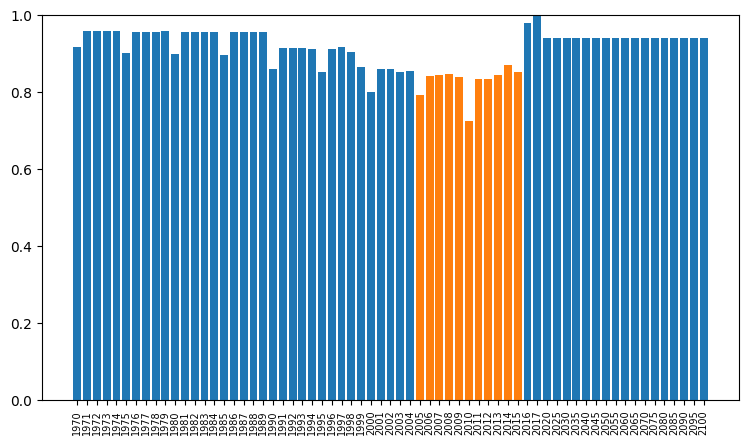

In [11]:
fig4, ax4 = plt.subplots(figsize=(9,5))

ax4.bar(np.arange(65), 
        np.isnan(np.array(EdStatsData.to_numpy()[:,4:-1], dtype=float)).mean(axis=0), 
        color=['C00']*35+['C01']*11+['C00']*20)
ax4.set_xticks(np.arange(65), labels=Dates_string, rotation=90, fontsize=7)
ax4.set_ylim(0,1)
fig4.set(label='Données manquantes par année')

Idisplay(fig4)

## repérage des indicateurs

Définition des fonctions utiles à l'élaboration d'indicateurs pertinents pour comparer les pays

In [12]:
def stats_indicator(indi:str):
    """
    prend un indicateur et donne ses statistiques sur tout le dataset

    :param indi: l'indicateur considéré
    :return: Un dataset généré avec pd.DataFrame.describe()
    """
    Q = EdStatsData.query("`Indicator Name` == @indi")
    return pd.DataFrame(Q[~Q["Country Name"].isin(regions)][Dates_string].to_numpy().ravel()).dropna().round(5).describe()

def income_cat(x):
    '''
    récupère une chaine de caractère de catégorie et renvoie l'entier correspondant
    ces catégories sont numérotées de 0 à 4 classées par ordre croissant
    Low income < Lower middle income < Upper middle income < High income: nonOECD < High income: OECD
    '''
    if x!=x : #vrai ssi x est NaN
        return x
    else :
        return income_int[list(income_groups).index(x)]

def get_lims(DS, indi:str):
    """
    renvoie les valeurs minimum et maximum relatives à un indicateur
    """
    Q = DS.query("`Indicator Name`==@indi")[Dates_string].to_numpy().ravel()
    Q = Q[~np.isnan(Q)]
    return Q.min(), Q.max()

def get_weighted(DS, indi:str, by:str):
    """
    Cette fonction utilise un dataset et un indicateur pour renvoyer un nouveau dataset des données de l'indicateur
    pondérées par la valeur de la population chaque année.

    :param DS: le dataset
    :param indi: l'indicateur qu'il faut pondérer
    :return: Le dataset résultat avec les mêmes colonnes mais de nouvelles lignes.
    """
    A = DS.copy()
    A.sort_values("Country Name", 0)
    Pop = A.query("`Indicator Name` == @by")
    Indi = A.query("`Indicator Name` == @indi")
    Pop.index = Indi.index = pd.Index(range(len(DS), len(DS)+len(Pop)))
    Indi[Dates_string] = Indi[Dates_string].div(Pop[Dates_string])
    Indi["Indicator Name"] = Indi["Indicator Name"] + " weighted by population"
    return Indi

def basic_stats(indi:str):
    """
    affiche des stats des base pour un indicateur
    - la ligne correspondante dans EdStatsSeries
    """
    
    Out1 = widgets.Output()
    Out2 = widgets.Output()
    Out3 = widgets.Output()
    H = widgets.HBox([Out2, Out3])
    V = widgets.VBox([Out1, H])
    
    miss_tab = EdStatsData.query("`Indicator Name` == @indi")[Dates_string].isna().mean(axis=1).to_numpy()

    fig5, ax5 = plt.subplots(figsize=(3,3))

    ax5.pie([miss_tab.mean(), 1-miss_tab.mean()],
            labels=['manquant', 'donnees'],
            autopct='%1.1f%%',
            labeldistance=0.3)
    ax5.axis('equal')

    with Out1 :
        Q = EdStatsSeries.query("`Indicator Name` == @indi")
        Idisplay(HTML(markdown.markdown(f'***\n## {indi}\n{Q["Long definition"].to_numpy()[0]}')))
        Idisplay(Q.dropna(axis=1))

    with Out2 :
        Idisplay(stats_indicator(indi))
    
    with Out3 :
        Idisplay(fig5)
        
    return V

Définition d'un multiIndex pour classifier les indicateurs choisis dans quatre catégories

In [13]:
Mindex = [('communication', 'Internet users (per 100 people)'),
          ('communication', 'Personal computers (per 100 people)'),
          ('economics',     'Income Group'),
          ('economics',     'GNI per capita, Atlas method (current US$)'),
          ('demographics',  'Population, total'),
          ('demographics',  'Population growth (annual %)'),
          ('demographics',  'Population, ages 13-19, total'),
          ('education',     'Enrolment in primary education, both sexes (number) weighted by population'),
          ('education',     'Enrolment in secondary education, both sexes (number) weighted by population'),
          ('education',     'Enrolment in tertiary education, all programmes, both sexes (number) weighted by population'),
          ('total',         'moyenne generale')]

Affichage dans un widget les statistiques basiques des indicateurs choisis

In [14]:
Out = [widgets.Output() for i in range(4)]

explo_indi = widgets.Tab()
explo_indi.children = Out
explo_indi.titles = ['communication', 'economics', 'demographics', 'education']

with Out[0] :
    Idisplay(basic_stats('Internet users (per 100 people)'))
    Idisplay(basic_stats('Personal computers (per 100 people)'))

income_groups = pd.unique(EdStatsCountry["Income Group"].dropna())
income_int = [3, 0, 2, 1, 4]

with Out[1] :
    Idisplay(HTML(markdown.markdown('''## Income Group\nThe categories differentiating the countries depending on their income levels''')))
    Idisplay(pd.DataFrame(EdStatsCountry["Income Group"].value_counts()))
    
    Idisplay(basic_stats('GNI per capita, Atlas method (current US$)'))

with Out[2] :
    Idisplay(basic_stats('Population, total'))
    Idisplay(basic_stats('Population growth (annual %)'))
    Idisplay(basic_stats('Population, ages 13-19, total'))

with Out[3] :
    Idisplay(basic_stats('Enrolment in primary education, both sexes (number)'))
    Idisplay(basic_stats('Enrolment in secondary education, both sexes (number)'))
    Idisplay(basic_stats('Enrolment in tertiary education, all programmes, both sexes (number)'))

EdStatsData = pd.concat((EdStatsData, 
                         get_weighted(EdStatsData, 'Enrolment in primary education, both sexes (number)', 'Population, ages 13-19, total'),
                         get_weighted(EdStatsData, 'Enrolment in secondary education, both sexes (number)', 'Population, ages 13-19, total'),
                         get_weighted(EdStatsData, 'Enrolment in tertiary education, all programmes, both sexes (number)', 'Population, ages 13-19, total')))

Idisplay(explo_indi)

# notation

chaque indicateur est associé à ses valeurs limites pour les calculs

In [15]:
selection =[('Internet users (per 100 people)', 0, 100, False),
            ('Personal computers (per 100 people)', 0, 100, False),
            ('Income Group', 0, 4, False),
            ('GNI per capita, Atlas method (current US$)', None, None, False),
            ('Population, total', None, None, True),
            ('Population growth (annual %)', None, None, True),
            ('Population, ages 13-19, total', None, None, True),
            ('Enrolment in primary education, both sexes (number) weighted by population', None, None, False),
            ('Enrolment in secondary education, both sexes (number) weighted by population', None, None, False),
            ('Enrolment in tertiary education, all programmes, both sexes (number) weighted by population', None, None, False)]

création des fonctions de calcul de notes

In [16]:
def normaliser(p:float, m:float, M:float, use_log=False):
    """normalise le point de données p entre m et M (m<M)"""
    if use_log :
        return np.log(p-m)/np.log(M-m)
    return (p-m)/(M-m)

def meilleur(DS, indi:str, cou:str):
    """
    renvoie la meilleure valeur pour l'indicateur et le pays donné
    On va chercher la valeur pour l'année 2015,
    sinon la première valeur antérieure disponible,
    sinon la moyenne de l'année 2015 pour l'indicateur
    """
    for y in get_Y_values(DS, indi, cou)[::-1]:
        if y==y and isinstance(y, float):
            return y
    
    Q = DS.query("`Indicator Name`==@indi")
    q1 = Q['2015'].dropna().mean()
    if q1 :
        return q1
    
    q2 = Q[Dates_string].to_numpy().ravel()
    return q2[~np.isnan(q2)].mean()

def note_indicateur(country, indicator, m=0, M=1, use_log=False):
    """
    Cette fonction prend un pays et trois informations d'indicateur : nom, portée min, portée max.
    Elle renvoie alors la note de l'indicateur pour le pays comme la moyenne des valeurs normalisées entre 2005 et 2015

    :param country: le nom du pays
    :param indicator: l'indicateur dont on veut calculer la note
    :param m: minimum de l'indicateur, 0 par défaut (optionnel)
    :param M: maximum de l'indicateur, 1 par défaut (optionnel)
    :param use_log: utilisation ou non de l'échelle logarithmique, False par défaut (optionnel)
    :return: La note de l'indicateur, moyenne des valeurs sur la période d'étude.
    """
    res = pd.NA
    if (m, M) == (None, None) :
        m, M = get_lims(EdStatsData, indicator)
    
    if indicator != 'Income Group': 
        return normaliser(meilleur(EdStatsData, indicator, country), m, M, use_log)
    else :
        Y = EdStatsCountry.query("`Table Name`==@country")
        return normaliser(income_cat(Y["Income Group"].iloc[0]), m, M)

def note(country, PB=None):
    """
    Cette fonction prend en entrée un pays et renvoie un dataset de chaque note qu'elle a obtenu pour tous les indicateurs,
    plus le score moyen
    
    :param country: Le pays à analyser
    :param PB: un paramètre optionnel pour faire évoluer une barre de chargement
    :return: Un dataset des notes.
    """
    if PB :
        PB.value = PB.value+1
    
    bull_index = pd.MultiIndex.from_tuples(Mindex, names=["categorie", "indicateur"])
    V = np.array([round(20*note_indicateur(country, *s), 2) for s in selection])
    res = pd.DataFrame(list(V)+[V[~np.isnan(V)].mean()], 
                       index=bull_index, 
                       columns=["note"],
                       dtype=float)
    res.columns.name = country
    return res

affichage du bulletin de notes pour un pays

In [17]:
bulletin = note('France')

countries_combobox = widgets.Combobox(
    value='France',
    placeholder='',
    options=list(countries),
    description='Country',
    ensure_option=True,
    disabled=False
)

def countries_combobox_eventhandler(change):
    clear_output()
    Idisplay(countries_combobox, note(change.new))
        
countries_combobox.observe(countries_combobox_eventhandler, names='value')

Idisplay(countries_combobox, bulletin)

Combobox(value='France', description='Country', ensure_option=True, options=('Aruba', 'Afghanistan', 'Angola',…

France                                                             note
categorie     indicateur                                               
communication Internet users (per 100 people)                    17.120
              Personal computers (per 100 people)                12.940
economics     Income Group                                       20.000
              GNI per capita, Atlas method (current US$)          4.160
demographics  Population, total                                  15.850
              Population growth (annual %)                       14.210
              Population, ages 13-19, total                      16.350
education     Enrolment in primary education, both sexes (num...  7.680
              Enrolment in secondary education, both sexes (n... 15.120
              Enrolment in tertiary education, all programmes...  9.570
total         moyenne generale                                   13.300

Calcul de la note pour chaque pays

Affichage des 10 pays les mieux notés